In [1]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rcut = 3.0  ##### Cut-off distance.
rcutsquare = rcut**2
g2 = 1./rcutsquare
g6 = g2*g2*g2
potcut = 4.*g6*(g6-1) ##### Term to be subtracted from pair potential energy

number = 5
Natoms = number**2  # No. of atoms
Ratom = 0.5  ### Radius of atom used to illustrate the atom as a sphere.
rho = 0.5 ### Number Density
L = math.pow(Natoms/rho,0.5) # Length of a side of the square containing the gas.
T0 = 120. # Natural temperature scale, T0 = epsilon/k.
T = 100.   # Temperature in Kelvin
dt = 1E-2  # Time step for Verlet Algorithm

In [3]:
##### Function to compute acceleration for a pair of atoms. 
## r12 is relative displacement of atoms.

def acceleration(r12): 
    r12square = np.dot(r12,r12)
    f2 = 1./r12square
    f6 = f2*f2*f2
    acc = 48.*f2*f6*(f6-0.5)*r12
    return acc

#### Function to compute potential energy for the system of particles. `pos' is the array of position vectors.
def potentialenergy(pos):
    potential = 0.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j] ## Relative position vector of the pair
            for l in range(2):  ### Calculating the correct separation between particles because of periodic boundary conditions.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            rijsquare = np.dot(rij,rij)
            if rijsquare < rcutsquare: # Imposing interaction cut-off
                f2 = 1./rijsquare
                f6 = f2*f2*f2
                potential += 4.*f6*(f6-1.) - potcut
    return potential


In [4]:
# Atoms are arranged initially in a square lattice 
# configuration with spacing between neighbors equal 
# to equilibrium separation.

equilib_sep = math.pow(2.,1./6.)  ## Equilibrium separation of atoms
wall_spacing = (L-(number-1)*equilib_sep)/2.## Distance between the walls and the initial array of atoms.
poslist = []  # List for positions of atoms
vlist = []   # List for velocities

################  Initialize positions and velocities ##############################################
x, y = wall_spacing, wall_spacing

for i in range(number):
    for j in range(number):
        xi, yi = x + equilib_sep*j, y + equilib_sep*i
        poslist.append((xi,yi))

####### Initially, all particles have the same speed but random velocity directions. ################
v0 = math.sqrt(2.*T/T0)

for i in range(Natoms):
    phi = 2*np.pi*np.random.random()
    vx = v0*np.cos(phi)
    vy = v0*np.sin(phi)
    vlist.append((vx,vy))
###################################################################################################

pos = np.array(poslist)  ### Converts lists to numpy arrays
v = np.array(vlist) ## Scaled velocity
V_cm = np.sum(v, axis = 0)/Natoms ## Correcting for CM velocity.
V = np.array([V_cm,]*Natoms)
v -= V  

In [7]:
time = 0. # Initial time.
t_final = 100. # Time upto which simulation is carried out.
potential_energy = potentialenergy(pos)
kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
energy = kinetic_energy + potential_energy
Time_List = [time]
Energy_List = [energy]
PotentialEnergy_List = [potential_energy]
KineticEnergy_List = [kinetic_energy]
iterations = int(t_final/dt) # Number of iterations of the Verlet Algorithm.
print(iterations)

10000


In [8]:
##################################### The Verlet Algorithm Loop ###################################
for step in tqdm(range(iterations)):
    pos += v*dt/2. ## Updating positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
    accel = np.zeros((Natoms,2)) ## Initialising acceleration array.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j]
            for l in range(2):  ### Calculating the correct separation between particles.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            if np.dot(rij,rij) < rcutsquare:
                acc = acceleration(rij) # Computing acceleration for a pair of particles.
                accel[i] += acc
                accel[j] -= acc
    v += accel*dt  ## Updating velocities.
    pos += v*dt/2. ## Final updating of positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
    potential_energy = potentialenergy(pos)
    kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
    energy = kinetic_energy + potential_energy
    Energy_List.append(energy)
    PotentialEnergy_List.append(potential_energy)
    KineticEnergy_List.append(kinetic_energy)
    time += dt
    Time_List.append(time)

100%|██████████| 10000/10000 [00:52<00:00, 190.68it/s]


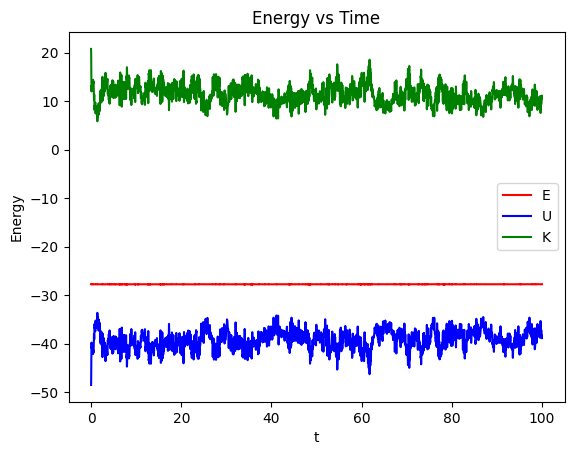

In [9]:
plt.xlabel('t') # Label for the x-axis
plt.ylabel('Energy') # Label for the y-axis
plt.title('Energy vs Time') # Title of plot
plt.plot(Time_List,Energy_List, color = 'r', label="E") 
plt.plot(Time_List,PotentialEnergy_List, color = 'b', label="U")
plt.plot(Time_List,KineticEnergy_List, color = 'g', label="K")
plt.legend();

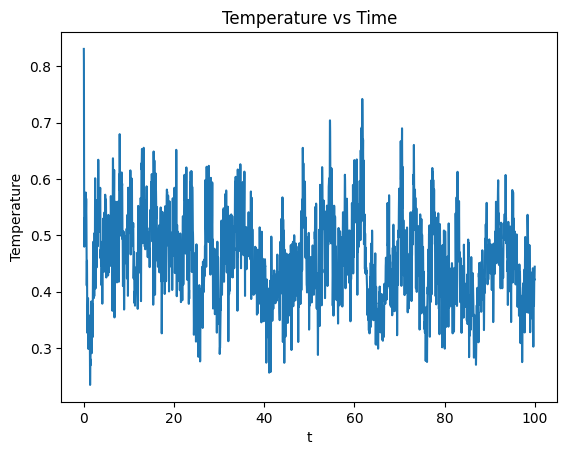

In [10]:
plt.xlabel('t') # Label for the x-axis
plt.ylabel('Temperature') # Label for the y-axis
plt.title('Temperature vs Time') # Title of plot
T_list = np.array(KineticEnergy_List)/Natoms
plt.plot(Time_List,T_list)